In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Checks for available GPUs and lists them
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Set TensorFlow to use only the first GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 1 Logical GPU


In [9]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence

In [10]:
# Load data
train_data = pd.read_csv('datasets/petfinder-adoption-prediction/train/train.csv')
test_data = pd.read_csv('datasets/petfinder-adoption-prediction/test/test.csv')
y_train = train_data['Type'].values - 1  # Types to 0 and 1 (cats and dogs)
y_test = test_data['Type'].values - 1    # Types to 0 and 1


In [11]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, pet_ids, labels, image_dir, batch_size=32, image_size=(224, 224), shuffle=True):
        'Initialization'
        self.pet_ids = pet_ids
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.pet_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pet_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        pet_ids_temp = [self.pet_ids[k] for k in indexes]

        # Generate data
        X_image = self.__load_images(pet_ids_temp)
        y = self.labels[indexes]

        return X_image, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __load_images(self, pet_ids_temp):
        'Loads and preprocesses images'
        images = np.empty((self.batch_size, *self.image_size, 3))
        for i, pet_id in enumerate(pet_ids_temp):
            image_path = os.path.join(self.image_dir, f'{pet_id}-1.jpg')
            if os.path.exists(image_path):
                image = load_img(image_path, target_size=self.image_size)
                image = img_to_array(image)
                images[i,] = preprocess_input(image)
            else:
                # If the image file does not exist, use a zero array as a placeholder
                images[i,] = np.zeros((*self.image_size, 3))
        return images


In [12]:
# Build CNN-only model
def build_cnn_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)  # Output layer for two classes (cat or dog)
    cnn_model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:  # Optionally, freeze layers
        layer.trainable = False
    return cnn_model

cnn_model = build_cnn_model((224, 224, 3))

In [13]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Initialize data generators
train_generator = DataGenerator(
    pet_ids=train_data['PetID'],
    labels=y_train,
    image_dir='../datasets/petfinder-adoption-prediction/train_images/',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True
)

validation_generator = DataGenerator(
    pet_ids=test_data['PetID'],
    labels=y_test,
    image_dir='../datasets/petfinder-adoption-prediction/test_images/',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True
)


In [14]:
# Train the model
history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=1
)

456/468 [============================>.] - ETA: 2s - loss: 0.6918 - accuracy: 0.5341

KeyboardInterrupt: 

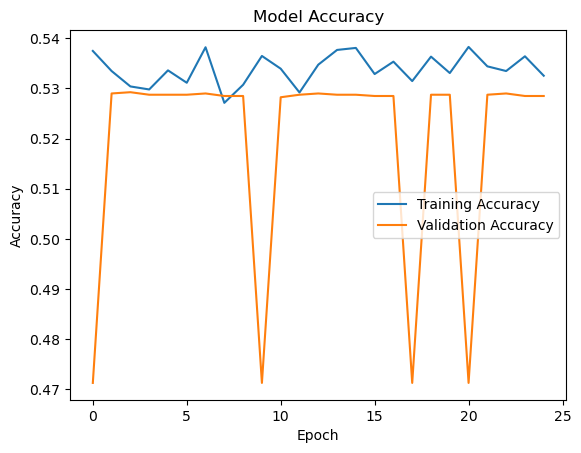

In [ ]:
# Plot accuracy per epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()